In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')
import sys, os, time
from slab import dsfit, dataanalysis
sys.path.append(r"S:\_Data\170422 - EonHe M018V6 with L3 etch")
from modules.Common import common
from experiment.data_cache import dataCacheProxy
from tqdm import tqdm
import scipy
print scipy.__version__
from mpltools import color

0.15.1


In [32]:
def get_f0s(fpts, mags, span=2E6):
    f0s, Qs = list(), list()

    for k in tqdm(range(np.shape(mags)[0])):
        center_freq = fpts[k, np.argmax(mags[k,:])]
        try:
            fr = dsfit.fitlor(fpts[k,:], dataanalysis.dBm_to_W(mags[k,:]), 
                              domain=[center_freq-span/2., center_freq+span/2.])
            f0s.append(fr[2])
            Qs.append(fr[2]/(2*fr[3]))
        except:
            print "Fit failed!" 
            f0s.append(np.nan)
            Qs.append(np.nan)
        
    return f0s, Qs

# Run from here

In [33]:
foldername = r"122022_determine_mu"
save = 1
f0_noE = 6.40511E9

filename = os.path.join(os.getcwd(), foldername, foldername+".h5")
d = dataCacheProxy(file_path=filename)

print d.index()
fpts = d.get('fpts')
mags = d.get('mags')
phases = d.get("phases")

Vres = d.get('Vres')
Vtrap = d.get('Vtrap')
Vrg = d.get('Vrg')
Vtg = d.get('Vtg')

nwa_config = d.get_dict("nwa_sweep_config")
voltage_log = d.get('voltage_log')

calibration_fpts = d.get('calibration_fpts')
calibration_idx = d.get('calibration_idx')
calibration_mags = d.get('calibration_mags')
calibration_phases = d.get('calibration_phases')

print nwa_config

[u'Vpinch', u'Vres', u'Vrg', u'Vtg', u'Vtrap', u'calibration_fpts', u'calibration_idx', u'calibration_mags', u'calibration_phases', u'fpts', u'mags', u'nwa_calibration_config', u'nwa_sweep_config', u'phases', u'temperature', u'time', u'voltage_log']
{u'power': array(-40), u'ifbw': array(500), u'stop': array(6407000000.0), u'start': array(6385000000.0), u'averages': array(1), u'sweep_points': array(401)}


In [53]:
f0s, Qs = get_f0s(calibration_fpts, calibration_mags, span=2E6)
f0i = (f0s[0]-f0_noE)/1E6

## Raw data

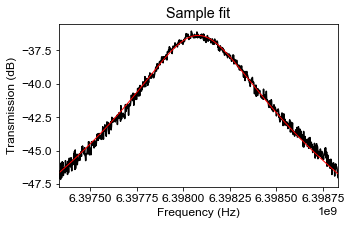

In [34]:
k = 1; span=2E6;
center_freq = calibration_fpts[k, np.argmax(calibration_mags[k,:])]
fr = dsfit.fitlor(calibration_fpts[k,:], dataanalysis.dBm_to_W(calibration_mags[k,:]), 
                  domain=[center_freq-span/2., center_freq+span/2.])

plt.figure(figsize=(5.,3.))
common.configure_axes(12)
plt.plot(calibration_fpts[k,:], calibration_mags[k,:], '-k')
plt.plot(calibration_fpts[k,:], 30 + 10*np.log10(dsfit.lorfunc(fr,calibration_fpts[k,:])), '-r', lw=1.0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission (dB)")
plt.xlim(np.min(calibration_fpts[k,:]), np.max(calibration_fpts[k,:]))
#print "Uncertainty in f0 in this fit is %.1f kHz"%(ferr[2]/1E3)
plt.title("Sample fit")

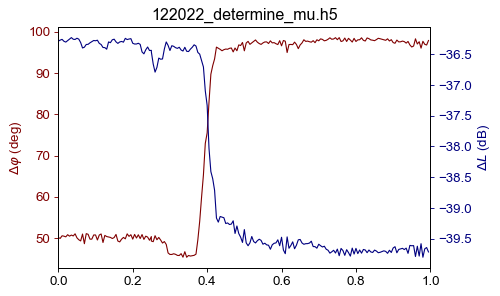

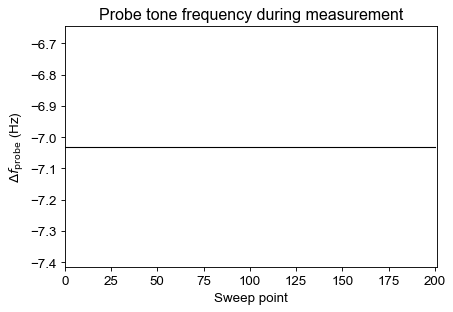

In [35]:
phases_mu = np.mean(phases, axis=1)
mags_mu = np.mean(mags, axis=1)
phases_std = np.std(phases, axis=1)
f0_mu = np.zeros(len(phases_mu))
adjusted_phases = np.zeros(len(phases_mu))
slopes = list()
offsets = list()

color1 = 'maroon'; color2 = 'navy'
idx = 0
fig = plt.figure()
plt.title(os.path.split(filename)[1])
ax1, ax2 = common.setup_twinax(color1=color1, color2=color2)
ax1.plot(Vtrap, phases_mu, color=color1, alpha=1, lw=1)
ax2.plot(Vtrap, mags_mu, '-', color=color2, alpha=1, lw=1)
ax1.set_ylabel(r"$\Delta \varphi$ (deg)")
ax2.set_ylabel(r"$\Delta L$ (dB)")
plt.xlim(0, 1)
plt.xlabel("$V_\mathrm{trap}$")
plt.legend(loc=0, prop={'size':10})

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

fig = plt.figure()
plt.plot((fpts[:,0]-f0_noE)/1E6, '-k', lw=1)
plt.xlabel("Sweep point")
plt.ylabel("$\Delta f_\mathrm{probe}$ (Hz)")
plt.title("Probe tone frequency during measurement")
plt.xlim(0, np.shape(fpts)[0])

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

## Correct for steps

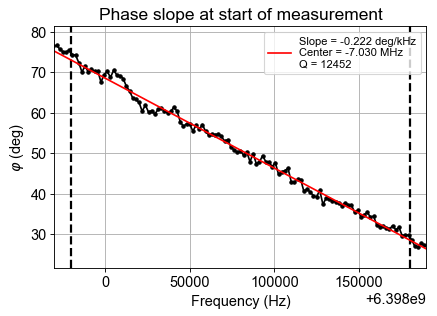

In [36]:
for k, calib_idx in enumerate(calibration_idx):
    center = fpts[calib_idx,0]
    span = 200E3
    fr = dsfit.fitlinear(calibration_fpts[k,:], calibration_phases[k,:], domain=(center-span/2., center+span/2.))
    slopes.append(fr[1])
    offsets.append(fr[0])
    
    phi0 = fr[0] + center*fr[1]
    if calib_idx == calibration_idx[-1]:
        adjusted_phases[calibration_idx[k]:] = phases_mu[calibration_idx[k]:]-slopes[0]*(center-fpts[0,0])
    else:
        adjusted_phases[calibration_idx[k]:calibration_idx[k+1]] = \
        phases_mu[calibration_idx[k]:calibration_idx[k+1]]-slopes[0]*(center-fpts[0,0])
        
f0_mu = -((adjusted_phases-offsets[0])/slopes[0] - fpts[0,0])

fig = plt.figure()
common.configure_axes(13)
plt.title("Phase slope at start of measurement")
center = fpts[0,0]
xmin, xmax = center-1.1*span/2., center+1.1*span/2.
fr = dsfit.fitlor(calibration_fpts[0,:], dataanalysis.dBm_to_W(calibration_mags[0,:]), domain=(center-1E6, center+1E6))
Q = fr[2]/(2*fr[3])

plt.plot(calibration_fpts[0,:], calibration_phases[0,:], '-ok', ms=3)
plt.xlim(xmin, xmax)
ymax = calibration_phases[0, common.find_nearest(calibration_fpts[0,:], xmin)]+5
ymin = calibration_phases[0, common.find_nearest(calibration_fpts[0,:], xmax)]-5
plt.ylim(ymin, ymax)
plt.plot(calibration_fpts[0,:], offsets[0]+calibration_fpts[0,:]*slopes[0], '-r', 
         lw=1.5, label="Slope = %.3f deg/kHz\nCenter = %.3f MHz\nQ = %.0f"%(slopes[0]*1E3, (center-f0_noE)/1E6, Q))
plt.vlines([center-span/2., center+span/2.], ymin, ymax, linestyles='--', lw=2.0)
plt.ylabel(r"$\varphi$ (deg)")
plt.xlabel(r"Frequency (Hz)")
plt.grid()
plt.legend(loc=0, prop={"size" : 10})

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

## Calibration

In [37]:
f0, Q = get_f0s(calibration_fpts, calibration_mags, span=1E6)

f0_noE = 6.40511e9
power = nwa_config['power']
averages = nwa_config['averages']

In [38]:
def f(p, x):
    return (p[0] + np.arctan((p[1]-x)/p[2]))*180/np.pi

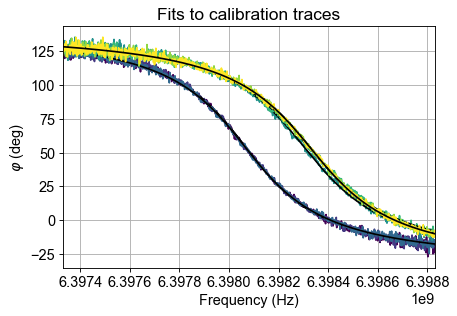

In [39]:
color.cycle_cmap(len(calibration_idx), cmap=plt.cm.viridis)
fitresults = list()
fitresults_mags = list()

plt.figure()
common.configure_axes(13)

for k, idx in enumerate(calibration_idx):
    plt.plot(calibration_fpts[k,:], calibration_phases[k,:])
    
    xdata = calibration_fpts[k,:]
    ydata = calibration_phases[k,:]

    fr=dsfit.fitgeneral(xdata, ydata, f, [50/180.*np.pi, 6.3985E9, 350E3])
    plt.plot(xdata, f(fr, xdata), '-k')
    fitresults.append(fr)
    
    fr_mags=dsfit.fitlor(xdata, calibration_mags[k,:])
    fitresults_mags.append(fr_mags)
    
center = calibration_fpts[0, np.argmax(calibration_mags[0,:])]
plt.xlim(np.min(calibration_fpts), np.max(calibration_fpts))
plt.grid()
plt.title("Fits to calibration traces")
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\varphi$ (deg)")

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

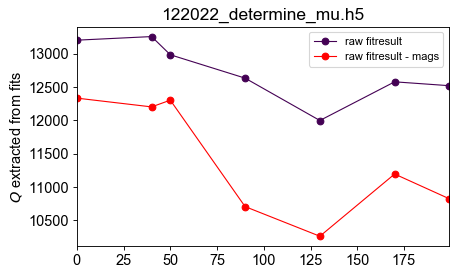

In [40]:
fig = plt.figure(figsize=(6.,8.))
plt.subplot(211)
plt.plot(calibration_idx, (np.array(fitresults)[:,1]/(2*np.array(fitresults)[:,2])), '-o', lw=1, label='raw fitresult')
plt.plot(calibration_idx, (np.array(fitresults_mags)[:,2]/(np.array(fitresults_mags)[:,3])), '-or', lw=1, 
         label='raw fitresult - mags')

plt.ylabel(r"$Q$ extracted from fits")
plt.xlim(0, calibration_idx[-1])
plt.legend(loc=0, prop={"size" : 10})
plt.title(os.path.split(filename)[1])

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

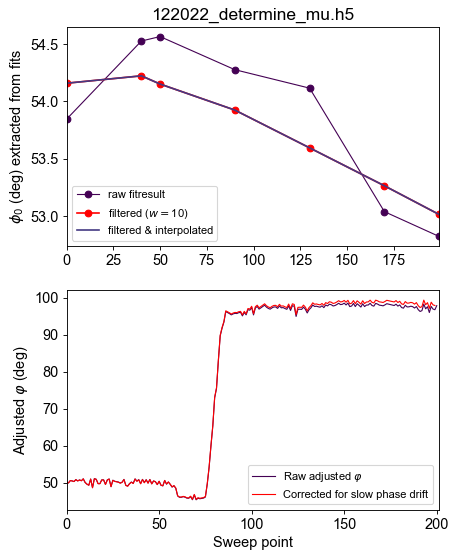

In [41]:
from scipy.interpolate import interp1d
from scipy import signal

window_len = 10
make_up = 1 if not(window_len%2) else 0
win = signal.hann(window_len)
y = np.array(fitresults)[:,0]*180/np.pi
y_prefilter = np.concatenate((y[0]*np.ones(int(window_len/2.-make_up)), y, y[-1]*np.ones(int(window_len/2.))))
y_filtered = signal.convolve(y_prefilter, win, mode='valid') / sum(win)

finterp = interp1d(calibration_idx, y_filtered, kind='linear', bounds_error=False)

fig = plt.figure(figsize=(6.,8.))
plt.subplot(211)
plt.title(os.path.split(filename)[1])
plt.plot(calibration_idx, np.array(fitresults)[:,0]*180/np.pi, '-o', lw=1, label='raw fitresult')
plt.plot(calibration_idx, y_filtered, '-o', color='r', label='filtered ($w=$%.d)'%window_len)
plt.plot(calibration_idx, finterp(calibration_idx), label='filtered & interpolated')
# plt.ylim(48, 51)
#plt.xlabel("Calibration index")
plt.ylabel(r"$\phi_0$ (deg) extracted from fits")
plt.xlim(0, calibration_idx[-1])
plt.legend(loc=0, prop={"size" : 10})

x = np.arange(0, len(adjusted_phases))

plt.subplot(212)
plt.plot(x, adjusted_phases, lw=1, label=r"Raw adjusted $\varphi$")
plt.plot(x, adjusted_phases-(finterp(x)-finterp(0)), '-r', lw=1, label="Corrected for slow phase drift")
plt.xlabel("Sweep point")
plt.ylabel(r"Adjusted $\varphi$ (deg)")
plt.xlim(0, len(adjusted_phases))
plt.legend(loc=0, prop={"size":10})

f0_mu_noslowdrift = -((adjusted_phases-(finterp(x)-finterp(0))-offsets[0])/slopes[0] - fpts[0,0])

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

In [42]:
def rgba(i, N):
    norm = matplotlib.colors.Normalize(vmin=0, vmax=N)
    cmap = plt.cm.plasma
    m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    return m.to_rgba(i)

def Vtrap_separated(Vrg, mu):
    f_mu = -1.755-7*mu
    return (f_mu-0.120) - 1.15*Vrg

def Vrg_separated(Vtrap, mu):
    f_mu = -1.755-7*mu
    return -1/1.15*(Vtrap+(0.120-f_mu))
    
def Vtrap_avalanche(mu):
    return -0.120 - 1.69*mu

def Vrg_iso(contour=0.020):
    if contour >= 0.010:
        return 1/1.15 * (-0.22-0.32-10*contour) * 1/(1 + 1/1.15)
    else:
        return np.nan

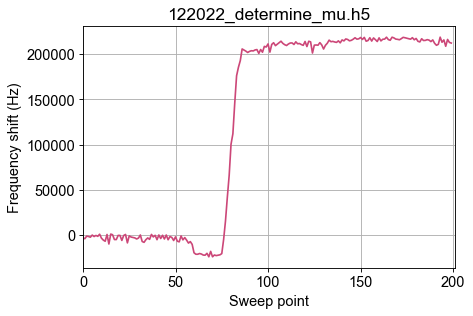

In [43]:
inflection_point_ind = np.append(np.append(np.zeros(1), np.where(np.abs(np.diff(Vrg, 2)) > 0.15E-3)[0]), 
                                 np.array([len(Vrg)]))
inflection_point_ind = inflection_point_ind.astype(np.int)
num_points = len(inflection_point_ind)

f0_nojumps = f0_mu_noslowdrift

fig = plt.figure()
common.configure_axes(13)
for n, point in enumerate(inflection_point_ind):
    if point != inflection_point_ind[0]:
        previous_point = int(inflection_point_ind[n-1])
        point = int(point)
        plt.plot(np.arange(previous_point, point), 
                 np.array(f0_nojumps[previous_point:point]), 
                 '-', mec='none', color=rgba(n, len(inflection_point_ind)))
plt.grid()
plt.xlabel("Sweep point")
plt.ylabel("Frequency shift (Hz)")
plt.xlim(0, len(f0_mu_noslowdrift))
plt.title(os.path.split(filename)[1])

# plt.ylim(-7E3, 2E3)
# plt.xlim(875, 910)

# if save:
#     common.save_figure(fig, save_path=os.path.split(filename)[0])

In [44]:
def Vtrap_to_mu(Vtrap_th):
    return -1/1.69 * (Vtrap_th + 0.120)

Vtrap_th = Vtrap[np.where(np.diff(f0_mu_noslowdrift)/np.diff(Vtrap) > 2E3/1E-3)[0]]
print Vtrap_th
Vtrap_th = Vtrap_th if isinstance(Vtrap_th, float) else Vtrap_th[1]
mu = Vtrap_to_mu(Vtrap_th)
print mu

c:\users\slab\appdata\local\enthought\canopy32\user\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
c:\users\slab\appdata\local\enthought\canopy32\user\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


[ 0.07   0.37   0.375  0.38   0.385  0.39   0.395  0.4    0.405  0.42 ]
-0.289940828402


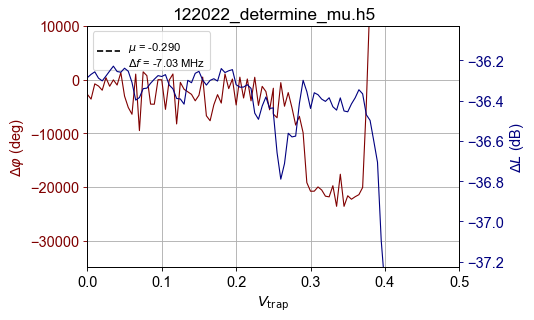

In [56]:
fig = plt.figure(figsize=(6., 4.))
common.configure_axes(13)
plt.title(os.path.split(filename)[1])

ax1_ymin = -35E3
ax1_ymax = 10E3

ax2_ymin = np.max(mags_mu) - 1
ax2_ymax = np.max(mags_mu) + 0.2

color1 = 'maroon'; color2 = 'navy'
idx = 0
plt.title(os.path.split(filename)[1])
ax1, ax2 = common.setup_twinax(color1=color1, color2=color2)
ax1.plot(Vtrap, np.array(f0_mu_noslowdrift), color=color1, alpha=1, lw=1)
ax1.set_ylabel(r"$\Delta \varphi$ (deg)")
ax2.set_ylabel(r"$\Delta L$ (dB)")
plt.xlabel("$V_\mathrm{trap}$")

# for n, point in enumerate(inflection_point_ind):
#     if point != inflection_point_ind[0]:
#         previous_point = inflection_point_ind[n-1]
#         plt.plot(Vtrap[previous_point:point], 
#                  np.array(f0_mu_noslowdrift)[previous_point:point], 
#                  '-', mec='none', color=rgba(n, len(inflection_point_ind)))

ax1.vlines(Vtrap_avalanche(mu), ymin, ymax, linestyles='--', color='k', 
           label="$\mu$ = %.3f\n$\Delta f$ = %.2f MHz" % (mu, f0i))
plt.legend(loc=3, prop={"size":10}, labelspacing=0.1, handletextpad=0.1)
ax2.plot(Vtrap, mags_mu, '-', color=color2, alpha=1, lw=1)

ax1.grid()
ax1.set_xlabel("$V_\mathrm{trap}$")
# plt.ylabel("Frequency shift (Hz)")
plt.xlim(0.0, 0.5)#np.max(Vtrap))
ax1.set_ylim(ax1_ymin, ax1_ymax)
ax2.set_ylim(ax2_ymin, ax2_ymax)
ax1.legend(loc=0, prop={'size':10})



# plt.subplot(312)        
# for n, point in enumerate(inflection_point_ind):
#     labels=["$V_\mathrm{rg}$", "$V_\mathrm{trap}$"] if n==1 else ["", ""]
#     if point != inflection_point_ind[0]:
#         previous_point = inflection_point_ind[n-1]
#         plt.plot(np.arange(previous_point, point), Vrg[previous_point:point], '--', 
#                  lw=3, mec='none', color=rgba(n, len(inflection_point_ind)), label=labels[0])
#         plt.plot(np.arange(previous_point, point), Vtrap[previous_point:point], '-', 
#                  lw=3, mec='none', color=rgba(n, len(inflection_point_ind)), label=labels[1])
        
# plt.legend(loc=0, prop={"size":10}, labelspacing=0.1, handletextpad=0.1)
# plt.xlim(-0.51, 0.05)
# plt.ylim(0.0, 0.30)

        
# plt.grid()
# plt.xlabel("Sweep point")
# plt.ylabel("Voltage")
# plt.xlim(0, len(Vtrap))

if save:
    common.save_figure(fig, save_path=os.path.split(filename)[0])

## Electron loading

In [46]:
try:
    f0_premeas = d.get('f0_pre_meas')
    Q_premeas = d.get('Q_pre_meas')
    
    fig = plt.figure()
    ax1, ax2 = common.setup_twinax(color1='b', color2='g')
    plt.title("Trying to regulate the electron density on the resonator")
    common.configure_axes(13)
    ax1.plot((f0_premeas-f0_noE)/1E6, '-o', color='b')
    ax2.plot(Q_premeas, '-d', color='g')
    ax2.set_ylabel("$Q$")
    ax1.set_ylabel("$\Delta f$ (MHz)")
    ax1.set_xlabel("Unloading attempt")

    if save:
        common.save_figure(fig, save_path=os.path.split(filename)[0])
except:
    print "No pre measurement traces found!"
    pass

No pre measurement traces found!
